# Student Depression Prediction - Modeling

Notebook này thực hiện training và evaluation các mô hình machine learning để dự đoán trầm cảm ở sinh viên.

**Models:**
1. Logistic Regression (baseline)
2. Decision Tree
3. Random Forest

**Metrics:**
- Accuracy, Precision, Recall, F1-Score, AUC-ROC
- SHAP Values for model interpretability

## 1. Setup & Import Libraries

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
)

# SHAP for model interpretability
import shap

warnings.filterwarnings("ignore")

# Display settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Processed Data

In [83]:
# Try to load from pickle first (faster), then CSV
try:
    df = pd.read_pickle("../results/processed_data.pkl")
    print("Loaded from pickle file")
except:
    df = pd.read_csv("../results/processed_data.csv")
    print("Loaded from CSV file")

print(f" Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")

Loaded from pickle file
 Dataset shape: 27870 rows × 52 columns


In [84]:
df.head()

,Age,Academic Pressure,CGPA,Study Satisfaction,Work/Study Hours,Financial Stress,Depression,Sleep_Encoded,Diet_Encoded,Gender_Encoded,Family_History_Encoded,Suicidal_Thoughts_Encoded,Degree_'Class 12',Degree_B.Arch,Degree_B.Com,Degree_B.Ed,Degree_B.Pharm,Degree_B.Tech,Degree_BA,Degree_BBA,Degree_BCA,Degree_BE,Degree_BHM,Degree_BSc,Degree_LLB,Degree_LLM,Degree_M.Com,Degree_M.Ed,Degree_M.Pharm,Degree_M.Tech,Degree_MA,Degree_MBA,Degree_MBBS,Degree_MCA,Degree_MD,Degree_ME,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD,Lifestyle_Score,Total_Stress,Study_Efficiency,Is_Class12,AcademicPressure_x_Lifestyle,FinancialStress_x_FamilyHistory,TotalStress_x_Lifestyle,Age_Group_Encoded,CGPA_Category_Encoded,Academic_Pressure_Level_Encoded,Financial_Stress_Level_Encoded,Risk_Score
0,33.0,5.0,8.97,2.0,3.0,1.0,1,1,2.0,0,0,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,6.0,2.2425,0,15.0,0.0,18.0,3,2,2,0,5.433333
1,24.0,2.0,5.90,5.0,3.0,2.0,0,1,1.0,1,1,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,4.0,1.4750,0,4.0,2.0,8.0,1,0,0,0,5.633333
2,31.0,3.0,7.03,5.0,9.0,1.0,0,0,2.0,0,1,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.0,4.0,0.7030,0,6.0,1.0,8.0,3,1,1,0,5.000000
3,28.0,3.0,5.59,2.0,4.0,5.0,1,2,1.0,1,1,1,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3.0,8.0,1.1180,0,9.0,5.0,24.0,2,0,1,2,9.066667
4,25.0,4.0,8.13,3.0,1.0,1.0,0,1,1.0,1,0,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2.0,5.0,4.0650,0,8.0,0.0,10.0,1,2,2,0,6.133333


## 3. Prepare Data for Modeling

In [85]:
# Define target and features
target = "Depression"

# Exclude non-numeric and categorical columns that aren't encoded
exclude_cols = [target]

# Get feature columns (numeric only)
feature_cols = [
    col
    for col in df.columns
    if col not in exclude_cols
    and df[col].dtype in ["int64", "float64", "int32", "float32", "bool"]
]

print(f" Features: {len(feature_cols)}")
print(f" Target: {target}")

 Features: 49
 Target: Depression


In [86]:
# Create X and y
X = df[feature_cols].copy()
y = df[target].copy()

# Handle any remaining NaN
X = X.fillna(X.median())

print(f"\n X shape: {X.shape}")
print(f" y shape: {y.shape}")
print(f"\n Target distribution:")
print(f"   No Depression (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"   Depression (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")


 X shape: (27870, 49)
 y shape: (27870,)

 Target distribution:
   No Depression (0): 11562 (41.5%)
   Depression (1): 16308 (58.5%)


## 4. Train/Test Split

In [87]:
# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Data split:")
print(f"   Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

 Data split:
   Training set: 22296 samples (80.0%)
   Test set: 5574 samples (20.0%)


In [88]:
# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

print(" Features scaled using StandardScaler")

 Features scaled using StandardScaler


## 5. Define Models

In [89]:
# Create models dictionary
models = {
    "Logistic Regression": LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced", max_depth=10, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        random_state=42,
        n_jobs=-1,
    ),
}

print(f" Defined {len(models)} models for training")

 Defined 3 models for training


## 6. Train & Evaluate Models

In [90]:
def evaluate_model(model, X_test, y_test):
    """Evaluate a trained model and return metrics."""
    y_pred = model.predict(X_test)

    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc_roc = roc_auc_score(y_test, y_prob)
    except:
        auc_roc = np.nan

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "AUC-ROC": auc_roc,
    }

In [91]:
# Train and evaluate all models
results = []
trained_models = {}

print(" Training models...")
print("=" * 60)

for name, model in models.items():
    print(f"\n Training {name}...")

    # Train
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    # Evaluate
    metrics = evaluate_model(model, X_test_scaled, y_test)
    metrics["Model"] = name
    results.append(metrics)

    print(f"    Accuracy: {metrics['Accuracy']:.4f}")
    print(f"    Recall: {metrics['Recall']:.4f}")
    print(f"    F1-Score: {metrics['F1-Score']:.4f}")
    print(f"    AUC-ROC: {metrics['AUC-ROC']:.4f}")

print("\n" + "=" * 60)
print(" All models trained!")

 Training models...

 Training Logistic Regression...
    Accuracy: 0.8439
    Recall: 0.8479
    F1-Score: 0.8641
    AUC-ROC: 0.9209

 Training Decision Tree...
    Accuracy: 0.8116
    Recall: 0.8271
    F1-Score: 0.8371
    AUC-ROC: 0.8640

 Training Random Forest...
    Accuracy: 0.8391
    Recall: 0.8685
    F1-Score: 0.8633
    AUC-ROC: 0.9156

 All models trained!


In [92]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index("Model")
results_df = results_df.sort_values("F1-Score", ascending=False)

print(" Model Comparison (sorted by F1-Score):")
results_df

 Model Comparison (sorted by F1-Score):


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Model,,,,,
Logistic Regression,0.843918,0.880892,0.847946,0.864105,0.920940
Random Forest,0.839074,0.858225,0.868486,0.863325,0.915585
Decision Tree,0.811625,0.847362,0.827100,0.837108,0.864027


## 7. Visualize Model Comparison

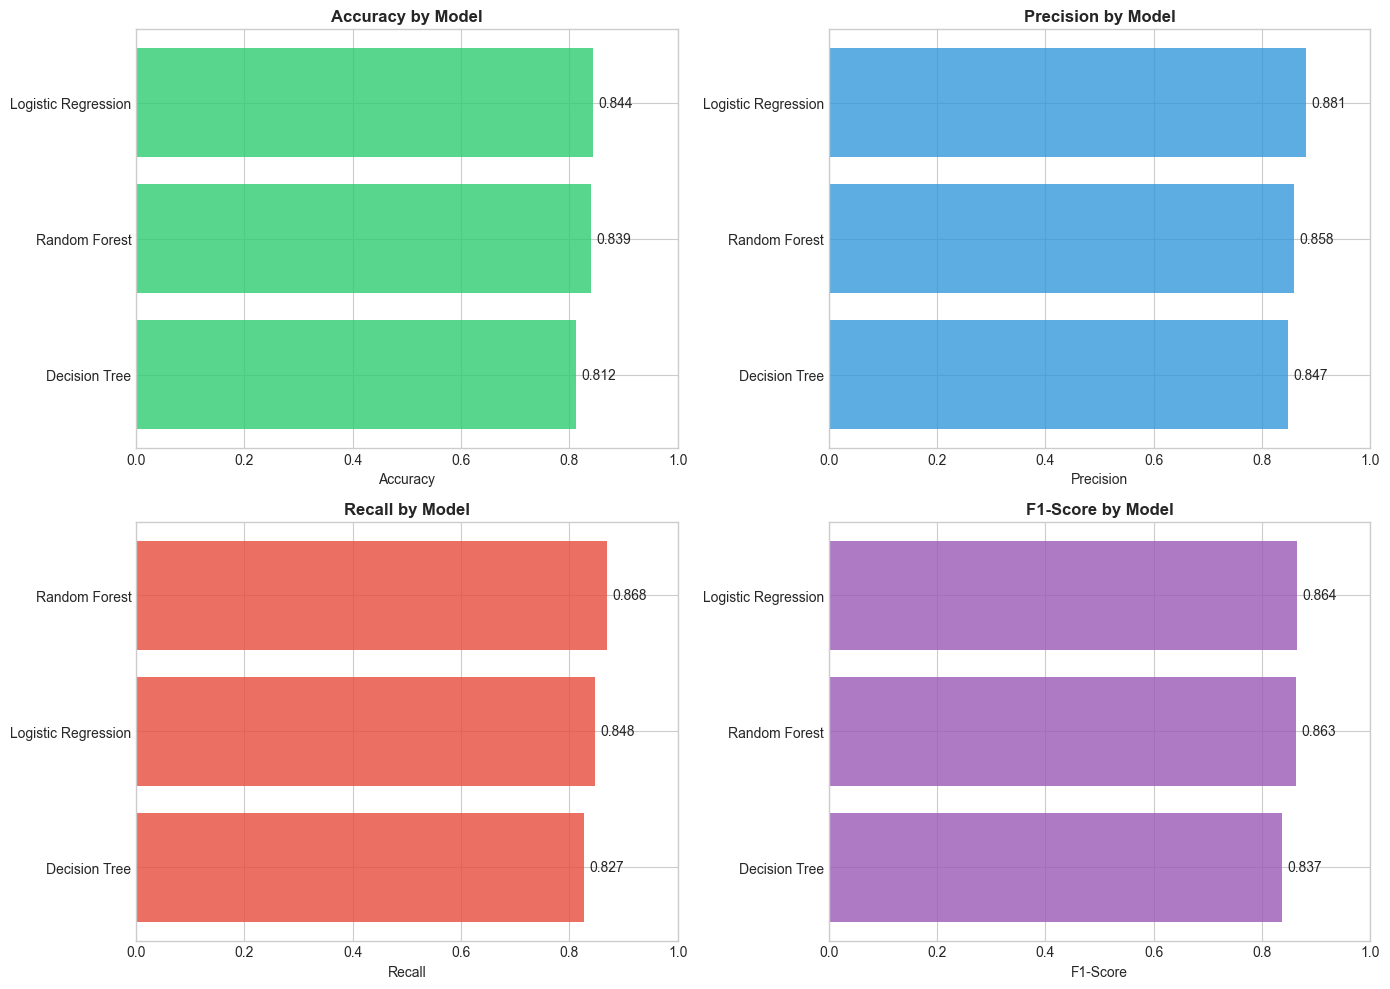

 Saved model comparison chart to results/model_comparison.png


In [93]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1-Score"]
colors = ["#2ecc71", "#3498db", "#e74c3c", "#9b59b6"]

for ax, metric, color in zip(axes.flatten(), metrics_to_plot, colors):
    data = results_df[metric].sort_values(ascending=True)
    bars = ax.barh(data.index, data.values, color=color, alpha=0.8)
    ax.set_xlabel(metric)
    ax.set_xlim(0, 1)

    # Add value labels
    for bar, val in zip(bars, data.values):
        ax.text(
            val + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.3f}",
            va="center",
            fontsize=10,
        )

    ax.set_title(f"{metric} by Model", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("../results/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print(" Saved model comparison chart to results/model_comparison.png")

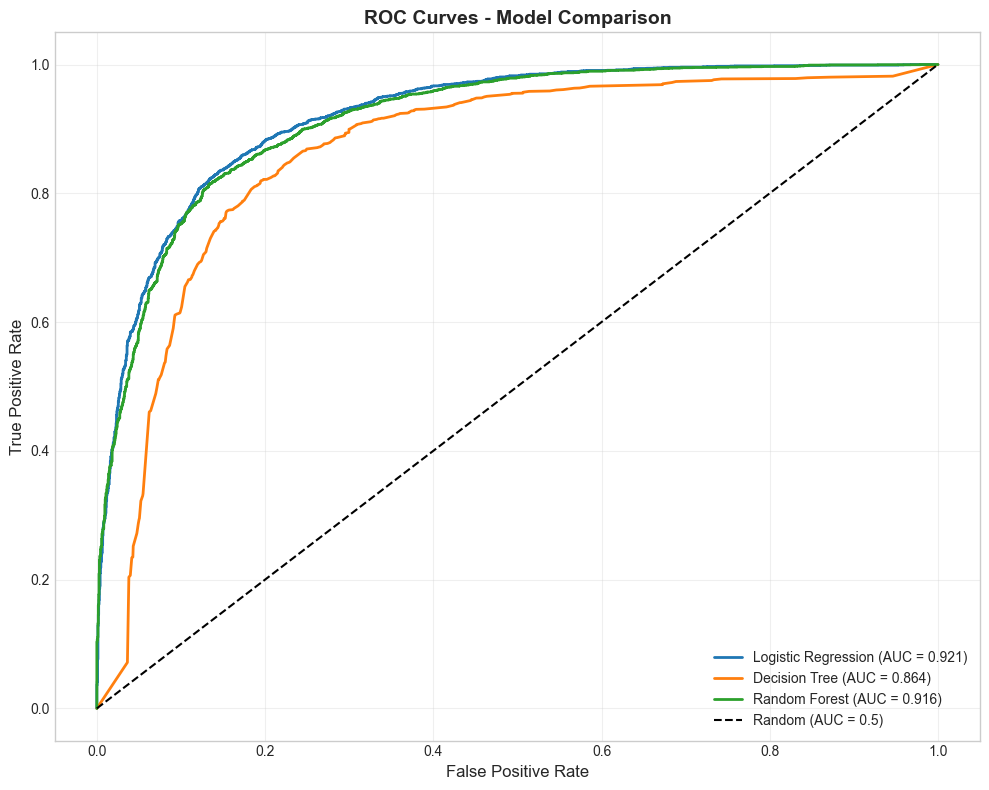

 Saved ROC curves to results/roc_curves.png


In [94]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in trained_models.items():
    try:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        ax.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2)
    except:
        pass

ax.plot([0, 1], [0, 1], "k--", label="Random (AUC = 0.5)")
ax.set_xlabel("False Positive Rate", fontsize=12)
ax.set_ylabel("True Positive Rate", fontsize=12)
ax.set_title("ROC Curves - Model Comparison", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print(" Saved ROC curves to results/roc_curves.png")

## 8. Best Model Analysis

In [95]:
# Get best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]

print(f" Best Model: {best_model_name}")
print("=" * 60)

 Best Model: Logistic Regression


In [96]:
# Detailed classification report
y_pred_best = best_model.predict(X_test_scaled)

print("\n Classification Report:")
print(
    classification_report(
        y_test, y_pred_best, target_names=["No Depression", "Depression"]
    )
)


 Classification Report:
               precision    recall  f1-score   support

No Depression       0.80      0.84      0.82      2312
   Depression       0.88      0.85      0.86      3262

     accuracy                           0.84      5574
    macro avg       0.84      0.84      0.84      5574
 weighted avg       0.85      0.84      0.84      5574



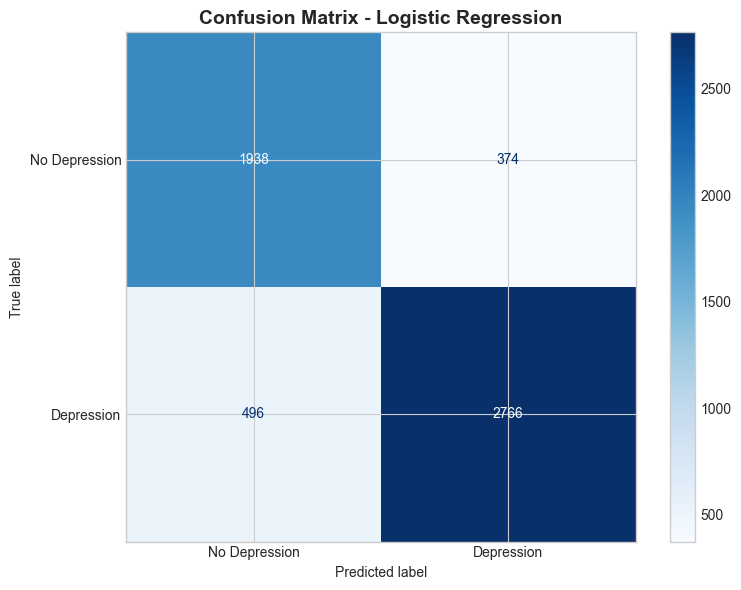


 Confusion Matrix Analysis:
   True Negatives (correctly predicted No Depression): 1938
   False Positives (wrongly predicted Depression): 374
   False Negatives (missed Depression cases): 496
   True Positives (correctly predicted Depression): 2766


In [97]:
# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Depression", "Depression"]
)
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Confusion Matrix - {best_model_name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../results/confusion_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n Confusion Matrix Analysis:")
print(f"   True Negatives (correctly predicted No Depression): {cm[0,0]}")
print(f"   False Positives (wrongly predicted Depression): {cm[0,1]}")
print(f"   False Negatives (missed Depression cases): {cm[1,0]}")
print(f"   True Positives (correctly predicted Depression): {cm[1,1]}")

## 9. SHAP Values Analysis

In [98]:
# Calculate SHAP values for the best model
print(f" Calculating SHAP values for {best_model_name}...")
print("=" * 60)

# Create appropriate explainer based on model type
if best_model_name == "Random Forest" or best_model_name == "Decision Tree":
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled)
    
    # For binary classification, use class 1 (Depression)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
else:
    # For Logistic Regression
    explainer = shap.LinearExplainer(best_model, X_train_scaled)
    shap_values = explainer.shap_values(X_test_scaled)

print(f" SHAP values calculated for {len(X_test_scaled)} test samples")

 Calculating SHAP values for Logistic Regression...
 SHAP values calculated for 5574 test samples


In [99]:
# Calculate mean absolute SHAP values for feature importance
shap_importance = pd.DataFrame({
    'Feature': feature_cols,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values('SHAP_Importance', ascending=False)
shap_importance['Rank'] = range(1, len(shap_importance) + 1)

print(f" Top 15 Features by SHAP Values - {best_model_name}")
print("=" * 60)

top_15 = shap_importance.head(15)
for _, row in top_15.iterrows():
    bar_len = int(row['SHAP_Importance'] / shap_importance['SHAP_Importance'].max() * 30)
    bar = "█" * bar_len
    print(f"   {row['Rank']:>2}. {row['Feature']:<35} | {bar} {row['SHAP_Importance']:.4f}")

 Top 15 Features by SHAP Values - Logistic Regression
    1. Suicidal_Thoughts_Encoded           | ██████████████████████████████ 0.9023
    2. Academic Pressure                   | ██████████████████ 0.5496
    3. Risk_Score                          | █████████████████ 0.5255
    4. Age                                 | █████████████████ 0.5174
    5. Total_Stress                        | ███████████████ 0.4518
    6. Work/Study Hours                    | ████████████ 0.3761
    7. Study Satisfaction                  | █████████ 0.3005
    8. Financial Stress                    | █████ 0.1707
    9. Diet_Encoded                        | ████ 0.1459
   10. CGPA                                | ██ 0.0727
   11. Lifestyle_Score                     | █ 0.0584
   12. Degree_'Class 12'                   | █ 0.0536
   13. Sleep_Encoded                       | █ 0.0489
   14. FinancialStress_x_FamilyHistory     | █ 0.0457
   15. Family_History_Encoded              | █ 0.0441



 Generating SHAP summary plot...


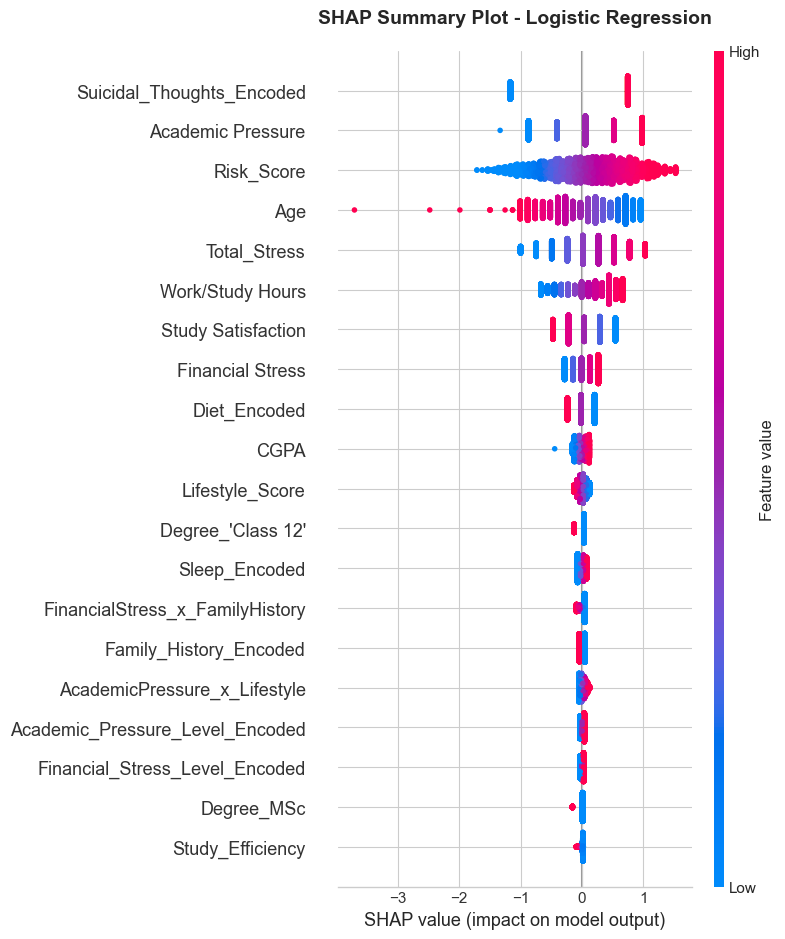

 Saved SHAP summary plot to results/shap_summary.png


In [100]:
# SHAP Summary Plot (beeswarm)
print("\n Generating SHAP summary plot...")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled, show=False, max_display=20)
plt.title(f"SHAP Summary Plot - {best_model_name}", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig("../results/shap_summary.png", dpi=150, bbox_inches="tight")
plt.show()

print(" Saved SHAP summary plot to results/shap_summary.png")

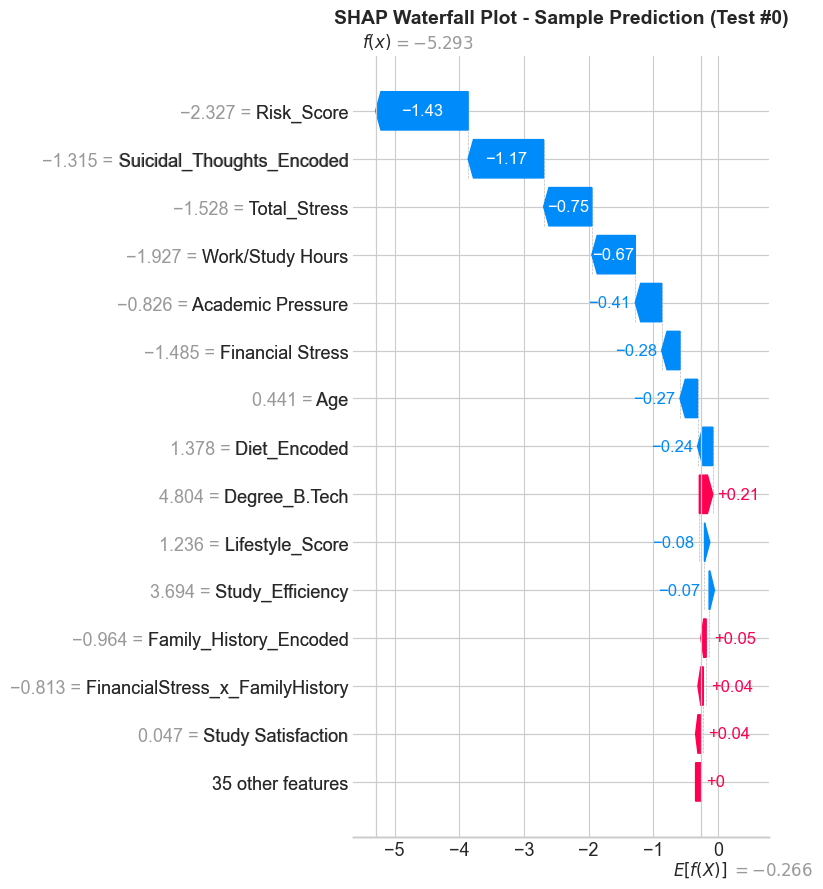

 Saved SHAP waterfall plot to results/shap_waterfall.png


In [101]:
# SHAP Waterfall plot for a sample prediction
sample_idx = 0
plt.figure(figsize=(12, 8))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value if not isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value[1],
    data=X_test_scaled.iloc[sample_idx].values,
    feature_names=feature_cols
), show=False, max_display=15)
plt.title(f"SHAP Waterfall Plot - Sample Prediction (Test #{sample_idx})", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("../results/shap_waterfall.png", dpi=150, bbox_inches="tight")
plt.show()

print(" Saved SHAP waterfall plot to results/shap_waterfall.png")

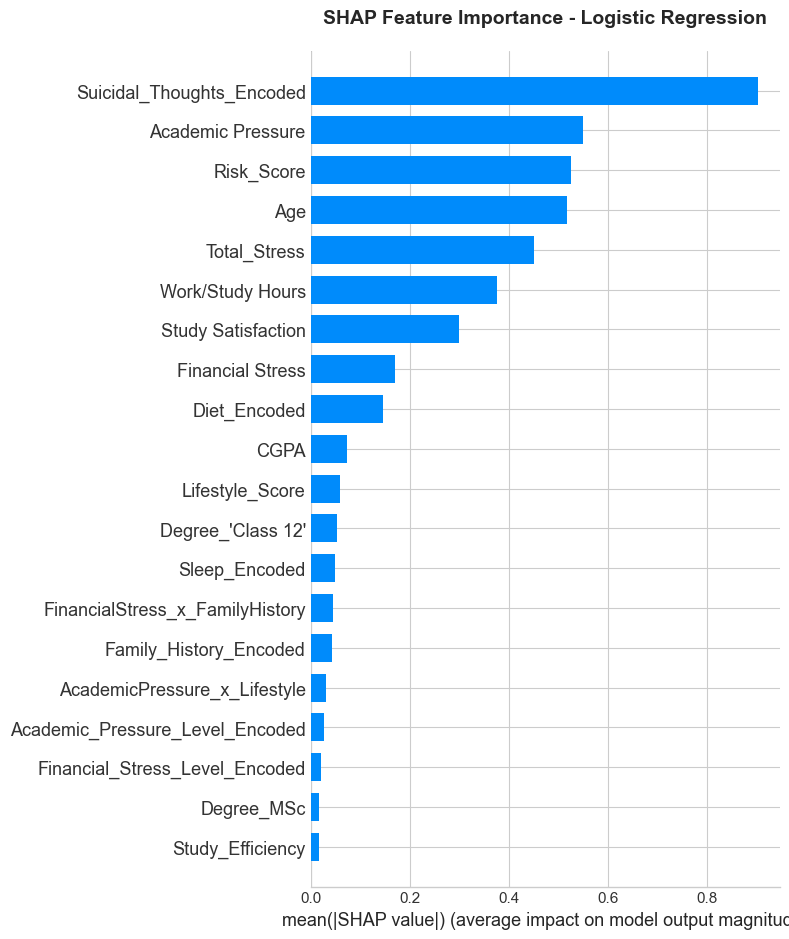

 Saved SHAP importance plot to results/shap_importance.png


In [102]:
# SHAP Bar Plot (mean absolute values)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False, max_display=20)
plt.title(f"SHAP Feature Importance - {best_model_name}", fontsize=14, fontweight="bold", pad=20)
plt.tight_layout()
plt.savefig("../results/shap_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print(" Saved SHAP importance plot to results/shap_importance.png")

## 10. Cross-Validation

In [103]:
# 5-Fold Cross-Validation for best model
print(f" 5-Fold Cross-Validation for {best_model_name}")
print("=" * 60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scale full dataset
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Cross-validation scores
cv_metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

cv_results = {}
for metric in cv_metrics:
    scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring=metric, n_jobs=-1)
    cv_results[metric] = {"mean": scores.mean(), "std": scores.std(), "scores": scores}
    print(f"   {metric:>12}: {scores.mean():.4f} ± {scores.std():.4f}")

 5-Fold Cross-Validation for Logistic Regression
       accuracy: 0.8445 ± 0.0046
      precision: 0.8803 ± 0.0068
         recall: 0.8500 ± 0.0038
             f1: 0.8648 ± 0.0037
        roc_auc: 0.9209 ± 0.0032


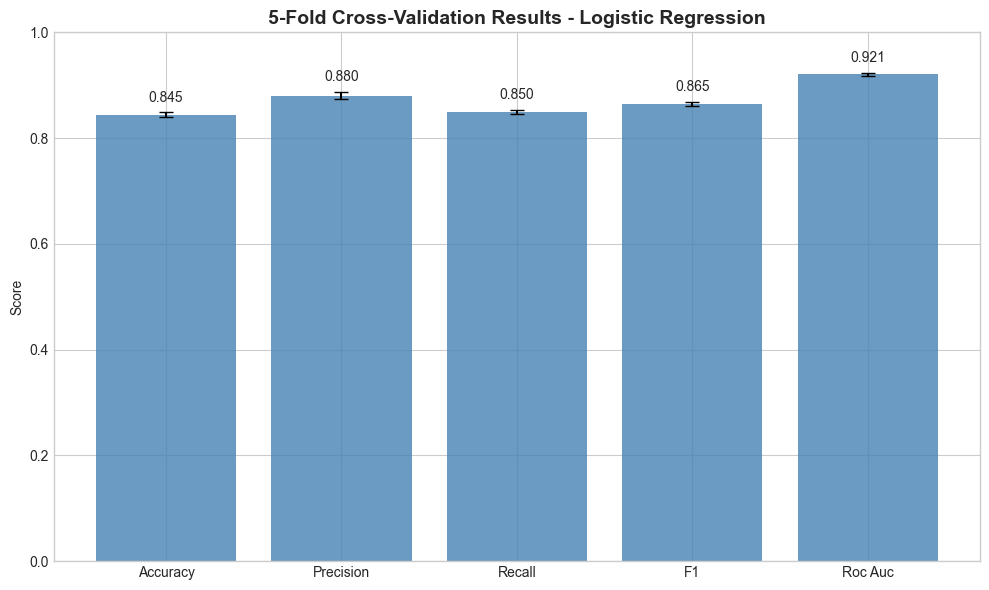

In [104]:
# Visualize CV results
fig, ax = plt.subplots(figsize=(10, 6))

metrics = list(cv_results.keys())
means = [cv_results[m]["mean"] for m in metrics]
stds = [cv_results[m]["std"] for m in metrics]

x = range(len(metrics))
bars = ax.bar(x, means, yerr=stds, capsize=5, color="steelblue", alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels([m.replace("_", " ").title() for m in metrics])
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_title(
    f"5-Fold Cross-Validation Results - {best_model_name}",
    fontsize=14,
    fontweight="bold",
)

# Add value labels
for bar, val, std in zip(bars, means, stds):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.02,
        f"{val:.3f}",
        ha="center",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

## 11. Save Results

In [105]:
# Save model comparison
results_df.to_csv("../results/model_comparison.csv")
print(" Saved model comparison to results/model_comparison.csv")

 Saved model comparison to results/model_comparison.csv


In [106]:
# Save SHAP importance
shap_importance.to_csv("../results/shap_importance.csv", index=False)
print(" Saved SHAP importance to results/shap_importance.csv")

 Saved SHAP importance to results/shap_importance.csv


In [107]:
# Save best model metrics
best_metrics = {
    "Model": best_model_name,
    "Accuracy": results_df.loc[best_model_name, "Accuracy"],
    "Precision": results_df.loc[best_model_name, "Precision"],
    "Recall": results_df.loc[best_model_name, "Recall"],
    "F1-Score": results_df.loc[best_model_name, "F1-Score"],
    "AUC-ROC": results_df.loc[best_model_name, "AUC-ROC"],
    "CV_F1_Mean": cv_results["f1"]["mean"],
    "CV_F1_Std": cv_results["f1"]["std"],
}

pd.DataFrame([best_metrics]).to_csv("../results/best_model_metrics.csv", index=False)
print(" Saved best model metrics to results/best_model_metrics.csv")

 Saved best model metrics to results/best_model_metrics.csv


## 12. Tổng kết

### Kết quả mô hình:

**Mô hình tốt nhất: Logistic Regression**
- **Accuracy**: 84.39% - Khả năng dự đoán chính xác tổng thể
- **Precision**: 88.09% - Độ chính xác khi dự đoán trầm cảm
- **Recall**: 84.79% - Khả năng phát hiện được các trường hợp trầm cảm thực tế
- **F1-Score**: 86.41% - Điểm cân bằng giữa Precision và Recall
- **AUC-ROC**: 92.09% - Khả năng phân biệt giữa hai lớp rất tốt
- **CV F1-Score**: 86.48% ± 0.37% - Mô hình ổn định qua các fold

### Top 10 đặc trưng quan trọng nhất (theo SHAP values):

1. **Suicidal_Thoughts_Encoded** (0.902) - Yếu tố quan trọng nhất
2. **Academic Pressure** (0.550) - Áp lực học tập
3. **Risk_Score** (0.525) - Điểm rủi ro tổng hợp
4. **Age** (0.517) - Tuổi
5. **Total_Stress** (0.452) - Tổng mức độ stress
6. **Work/Study Hours** (0.376) - Số giờ học/làm việc
7. **Study Satisfaction** (0.301) - Mức độ hài lòng với việc học
8. **Financial Stress** (0.171) - Căng thẳng tài chính
9. **Diet_Encoded** (0.146) - Chế độ ăn uống
10. **CGPA** (0.073) - Điểm trung bình

### Những phát hiện chính:

1. **Sức mạnh của SHAP values**:
   - Cho thấy rõ ràng **Suicidal_Thoughts** là yếu tố quyết định nhất (gấp 1.6 lần yếu tố thứ 2)
   - Các yếu tố tâm lý (Academic Pressure, Total_Stress) có tác động mạnh hơn yếu tố học tập (CGPA)
   - Features kỹ thuật (Risk_Score, Total_Stress) giúp tăng khả năng dự đoán

2. **So sánh với Feature Importance truyền thống**:
   - SHAP values cung cấp cái nhìn sâu hơn về ảnh hưởng thực tế của features
   - Hiển thị cả magnitude và direction của impact
   - Cho phép giải thích individual predictions qua Waterfall plot

3. **Ý nghĩa thực tiễn**:
   - Model có thể phát hiện được 84.79% trường hợp trầm cảm thực tế (Recall cao)
   - Precision 88.09% giúp giảm false positives, tránh gây lo lắng không cần thiết
   - Cross-validation ổn định (std = 0.37%) cho thấy model đáng tin cậy
   - CGPA có tầm quan trọng thấp (0.073) xác nhận rằng điểm số không phải yếu tố chính gây trầm cảm

4. **Khuyến nghị**:
   - Ưu tiên theo dõi sinh viên có suicidal thoughts
   - Chú ý đến academic pressure và total stress levels
   - Cân nhắc can thiệp sớm dựa trên risk score
   - Không nên đánh giá rủi ro trầm cảm chỉ dựa trên điểm số